# Customer churn analysis


# Machine Learning Pipeline

In this notebook, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. **Extracting training data from offline Feast feature store**
2. **Feature Engineering**
3. **Feature Selection**
4. **Model Training**
5. **Checking model predictions using Feast online feature store**
6. **Obtaining Predictions / Scoring**

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf, col
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

# import feast to retrieve training dataset for model training
from feast import FeatureStore
from datetime import datetime

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

In [2]:
#Snowflake connection info
from config import snowflake_conn_prop
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(1, 0, 0)
[Row(CURRENT_WAREHOUSE()='LAB_S_WH', CURRENT_DATABASE()='FEAST_SF', CURRENT_SCHEMA()='PUBLIC')]


## Generate training dataset from Feast Offline Feature Store

In [3]:
#Check if Feast is properly installed on your machine
!pip show feast

Name: feast
Version: 0.28.0
Summary: Python SDK for Feast
Home-page: https://github.com/feast-dev/feast
Author: Feast
Author-email: 
License: Apache
Location: /Users/rsaxena/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages
Requires: bowler, click, colorama, dask, dill, fastapi, fastavro, google-api-core, googleapis-common-protos, grpcio, grpcio-reflection, Jinja2, jsonschema, mmh3, numpy, pandas, pandavro, proto-plus, protobuf, pyarrow, pydantic, pygments, PyYAML, SQLAlchemy, tabulate, tenacity, toml, tqdm, typeguard, uvicorn
Required-by: 


In [4]:
# Identify the customer records that will be used for training purpose
cust = session.table('DEMOGRAPHICS').sample(n = 40000,sampling_method = 'BERNOULLI').select(col("CUSTOMERID"))
custid = cust.to_pandas()
custid.sample(5)

,CUSTOMERID
9335,8151-INmdB
27668,4359-GSaFv
1553,1796-Eq5nb
28427,7586-egUzw
29912,3408-pC0cI


In [5]:
# Initialize the entity dataframe for which the features are required to be extracted from the feature store

customers = pd.DataFrame(
    {
       "event_timestamp": datetime.now(),
       "CUSTOMERID": custid["CUSTOMERID"].tolist(),
    }
)

customers.sample(5)

,event_timestamp,CUSTOMERID
8299,2023-01-10 13:57:37.314900,2226-mwsi2
15760,2023-01-10 13:57:37.314900,4756-3rEwX
26937,2023-01-10 13:57:37.314900,9424-VGkCE
5671,2023-01-10 13:57:37.314900,7012-XubeG
17273,2023-01-10 13:57:37.314900,7346-X6VOc


In [6]:
!pwd
# your current directory should be .../sfguide-getting-started-snowpark-python-feast

/Users/rsaxena/Documents/GitHub/sfguide-getting-started-snowpark-python-feast


In [7]:
# CD to the feature_repo folder

%cd customer_repo/feature_repo

/Users/rsaxena/Documents/GitHub/sfguide-getting-started-snowpark-python-feast/customer_repo/feature_repo


In [8]:
# Generate training dataset from Feast offline feature store

fs = FeatureStore(repo_path=".")  # Initialize the feature store

feature_service = fs.get_feature_service("customer_info")
fs.get_historical_features(features=feature_service, entity_df=customers).to_snowflake(table_name='OFFLINE_FEATURES')
# Training dataset is computed and stored within Snowflake in 'OFFLINE_FEATURES' table without leaving Snowflake

In [9]:
data = session.table('OFFLINE_FEATURES') # snowpark dataframe on offline feature table created in the previous cell
data.show(5)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"event_timestamp"           |"CUSTOMERID"  |"GENDER"  |"SENIORCITIZEN"  |"PARTNER"  |"DEPENDENTS"  |"PHONESERVICE"  |"MULTIPLELINES"  |"INTERNETSERVICE"  |"ONLINESECURITY"     |"ONLINEBACKUP"       |"DEVICEPROTECTION"   |"TECHSUPPORT"        |"STREAMINGTV"        |"STREAMINGMOVIES"    |"CONTRACT"      |"PAPERLESSBILLING"  |"PAYMENTMETHOD"          |"MONTHLYCHARGES"  |"TOTALCHARGES"  |"TENUREMONTHS"  |"CHURNVALUE"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# We will now bring the data into the model training environment to train the model
data = data.to_pandas()
data.shape

(40000, 22)

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [11]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

# to divide train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['CHURNVALUE','CUSTOMERID', 'event_timestamp'], axis=1), # predictive variables
    data['CHURNVALUE'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape


((32000, 19), (8000, 19))

## Let's identify the different variables

In [12]:
# Since we already cleaned up the data using snowpark, identifying variable is super easy

# we will capture those of type *object*

cat_vars = ['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
            'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
            'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']

# we will capture those of type numerical from previous notebook
num_vars = [ 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']

features = cat_vars + num_vars
print(features)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


## Numerical variable transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the MinMaxScaler in order to get a more Gaussian-like distribution. Use ordinal encoding for the categorical variables and check for nulls


In [13]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

In [14]:
# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)) ,
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x7f921f14f310>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

## Check the model predictions using Feast Online Feature Store

In [15]:
fs.materialize_incremental(end_date=datetime.now())

online_features = fs.get_online_features(
    features=feature_service, entity_rows=[{"CUSTOMERID": '7090-ZyCMx'}],
).to_dict()

online_features

Materializing 2 feature views to 2023-01-10 13:57:43+11:00 into the snowflake.online online store.

cust_services from 2023-01-11 00:52:23+11:00 to 2023-01-10 13:57:43+11:00:
cust_demographics from 2023-01-11 00:52:23+11:00 to 2023-01-11 00:57:43+11:00:


{'CUSTOMERID': ['7090-ZyCMx'],
 'DEPENDENTS': [True],
 'PARTNER': [False],
 'GENDER': ['Female'],
 'SENIORCITIZEN': [False],
 'PAPERLESSBILLING': ['true'],
 'TENUREMONTHS': [2.0],
 'PAYMENTMETHOD': ['Electronic check'],
 'MONTHLYCHARGES': [70.7],
 'INTERNETSERVICE': ['Fiber optic'],
 'TOTALCHARGES': [151.65],
 'ONLINESECURITY': ['No'],
 'STREAMINGTV': ['No'],
 'STREAMINGMOVIES': ['No'],
 'CONTRACT': ['Month-to-month'],
 'MULTIPLELINES': ['No'],
 'ONLINEBACKUP': ['No'],
 'CHURNVALUE': [1.0],
 'TECHSUPPORT': ['No'],
 'DEVICEPROTECTION': ['No'],
 'PHONESERVICE': ['Yes']}

In [16]:
# Remove the features that were not used to train the model
online_ft = online_features
del online_ft['CUSTOMERID']
del online_ft['CHURNVALUE']

online_ft

In [18]:
# Sort the features in the order in which they were used to train the model
sorted_online_ft = {i: online_ft[i] for i in X_train.columns}

sorted_online_ft

In [20]:
# Model prediction based on the features extraced from Feast Online Feature Store
model.predict(pd.DataFrame.from_dict(sorted_online_ft))[0]

/Users/rsaxena/opt/anaconda3/envs/getting_started_snowpark_python/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


1.0

## Check Accuracy of our model on test dataset

In [21]:
y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 99.43%


## Confusion Matrix

In [22]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  2580
False Positive(FP) =  18
True Negative(TN)  =  5381
False Negative(FN) =  21
Accuracy of the classification = 0.995


## Check for important features

Text(0.5, 0, 'Feature Importance')

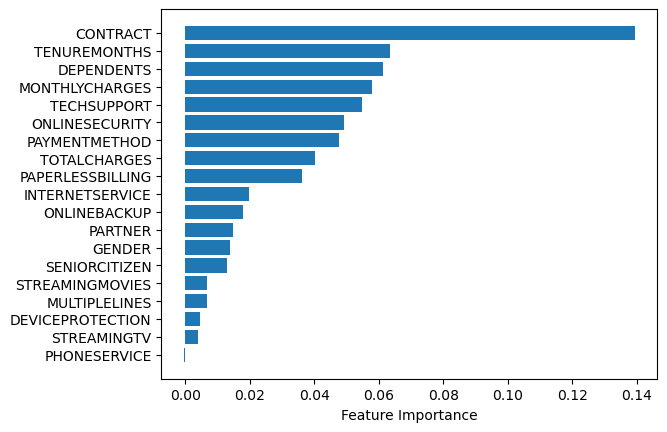

In [23]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

## Prepare for model deployment in Snowflake using Snowpark Python UDF

In [24]:
#Let's first create a stage to store the artifacts
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


### We will define a snopark python UDF to help us score the live data using the model that we built earlier. 

Since we have fitted the model with the scikit learn pipeline, our UDF will do the transformations and also score the new data

In [25]:
%%time

features = list(X_train.columns)

session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")

@udf(name='predict_churn',is_permanent = True, stage_location = '@MODELSTAGE', replace=True)
def predict_churn(args: list) -> float:
    row = pd.DataFrame([args], columns=features)
    return model.predict(row)

CPU times: user 1.58 s, sys: 199 ms, total: 1.78 s
Wall time: 22.6 s


In [26]:
# Inference dataset
new_df = session.table('OFFLINE_FEATURES').sample(n = 400)

In [27]:
%%time
new_df.select(new_df.CUSTOMERID,new_df.CHURNVALUE, \
              F.call_udf("predict_churn", F.array_construct(*features)).alias('PREDICTED_CHURN')) \
        .write.mode('overwrite').saveAsTable('churn_detection')


CPU times: user 10.8 ms, sys: 3.58 ms, total: 14.3 ms
Wall time: 13.3 s


In [28]:
session.table('churn_detection').toPandas()

,CUSTOMERID,CHURNVALUE,PREDICTED_CHURN
0,6648-C8JMl,1.0,1.0
1,8579-H2bGq,0.0,0.0
2,8799-jD3Sz,0.0,0.0
3,2849-QFeUt,1.0,1.0
4,2509-qNZeT,1.0,1.0
...,...,...,...
395,9499-L9nZG,0.0,0.0
396,6310-aKSK5,0.0,0.0
397,6651-0IZkT,1.0,1.0
398,5093-uCxMc,0.0,0.0


## Different Syntax to register the prediction UDF for deployment

In [29]:
%%time
session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")
features = list(X_train.columns)
predict_churn_model = session.udf.register(lambda *args: 
                                    model.predict(pd.DataFrame(args, columns=features)),
                                    name="predict_churn_model",
                                    stage_location="@MODELSTAGE",
                                    return_type=FloatType(),
                                    is_permanent=True,
                                    replace=True,
                                    input_types=[ArrayType()])

CPU times: user 1.25 s, sys: 140 ms, total: 1.39 s
Wall time: 22.1 s


## if we want to do the prediction using SQL

In [30]:
%%time
session.sql(' select customerid,churnvalue, \
            predict_churn_model(ARRAY_CONSTRUCT( \
                                    GENDER, \
                                    SENIORCITIZEN, \
                                    PARTNER, \
                                    DEPENDENTS, \
                                    PHONESERVICE, \
                                    MULTIPLELINES,  \
                                    INTERNETSERVICE,  \
                                    ONLINESECURITY,  \
                                    ONLINEBACKUP, \
                                    DEVICEPROTECTION,  \
                                    TECHSUPPORT,  \
                                    STREAMINGTV,  \
                                    STREAMINGMOVIES, \
                                    CONTRACT,  \
                                    PAPERLESSBILLING,  \
                                    PAYMENTMETHOD,  \
                                    TENUREMONTHS, \
                                    MONTHLYCHARGES,  \
                                    TOTALCHARGES)) as Churn_prediction \
                                    from OFFLINE_FEATURES sample (10 rows)').show()

----------------------------------------------------
|"CUSTOMERID"  |"CHURNVALUE"  |"CHURN_PREDICTION"  |
----------------------------------------------------
|7836-xlpCI    |0.0           |0.0                 |
|7444-eUtS7    |0.0           |0.0                 |
|8607-R3UsY    |0.0           |0.0                 |
|3157-IjqlP    |0.0           |0.0                 |
|4260-H3giG    |0.0           |0.0                 |
|3413-GivcT    |0.0           |0.0                 |
|5691-lA1sX    |0.0           |1.0                 |
|2364-poczo    |0.0           |1.0                 |
|8274-5ZiE7    |1.0           |1.0                 |
|9838-msIwa    |0.0           |1.0                 |
----------------------------------------------------

CPU times: user 5.71 ms, sys: 2.73 ms, total: 8.44 ms
Wall time: 3.4 s


In [31]:
session.close()

# Congratulations !! You have successfully completed the lab

## Environment Reset Steps

### Remove Feast setup
1. Open Terminal window and CD to .../sfguide-getting-started-snowpark-python-feast/customer_repo/feature_repo folder
2. Run **feast teardown**

### Remove Snowflake setup
1. Open Snowsight and login as the user specified to run the lab
2. Open SQL worksheet and run following commands
```
use role accountadmin;
drop database feast_sf;
```